# Pairwise conservative kernel for two chemical species

In [9]:
# import libraries
import theano
import theano.tensor as T
from theano import function
import numpy as np

### Definitions

Define the position of the atoms relative to the centrla one, and their chemical species, by a matrix of dimension Mx5

In [10]:
# positions of central atoms
r1, r2 = T.dvectors('r1d','r2d') 

# positions of neighbours 
rho1, rho2 = T.dmatrices('rho1','rho2') 

# hyperparameter
sig = T.dscalar('sig') 

In [11]:
# positions of neighbours without chemical species

rho1s = rho1[:, 0:3]
rho2s = rho2[:, 0:3]


alpha_1 = rho1[:, 3:4].flatten()
alpha_2 = rho2[:, 3:4].flatten()
alpha_j = rho1[:, 4:5].flatten()
alpha_m = rho2[:, 4:5].flatten()

Calculate the relative distance to the central vector

In [12]:
# first configuration
r1j = T.sqrt(T.sum((rho1s[:, :]-r1[None,:])**2, axis = 1))

# second configuration
r2m = T.sqrt(T.sum((rho2s[:, :]-r2[None,:])**2, axis = 1))


Calculate the mask given by the chemical species

In [13]:
def delta_alpha(a1j, a2m):
    d = (a1j == a2m)
    dn =  float(d == 'true')
    return dn

In [14]:
# !!! THIS IS NOT AN EXACT KRONECKER SYMBOL !!!

def delta_alpha2(a1j, a2m):
    
    d = np.exp(-(a1j - a2m)**2/(2*(1e-5)**2))
    #d = np.exp((a1j[0] - a2m[0])**2/(2*(1e-7)**2))
    #dp = np.exp((a1j[1] - a2m[1])**2/(2*(1e-7)**2))
    
    return d

In [15]:
delta_alpha2(100, 100)

1.0

In [16]:
delta_alphas12 = delta_alpha2(alpha_1[:, None] , alpha_2[None, :])
delta_alphasjm = delta_alpha2(alpha_j[:, None] , alpha_m[None, :])

In [17]:
delta_alphas1m = delta_alpha2(alpha_1[:, None] , alpha_m[None, :])
delta_alphasj2 = delta_alpha2(alpha_j[:, None] , alpha_2[None, :])

### Kernel

Build the kernel

In [18]:
# kernel
k = T.sum(T.exp(-(r1j[:, None] - r2m[None,:])**2/sig) * (delta_alphas12 * delta_alphasjm + delta_alphas1m * delta_alphasj2))    



In [19]:
# energy energy kernel
kfun = function([r1, r2, rho1, rho2, sig], k)

Take single and doble derivatives

In [21]:
# energy force kernel
G2b_ms = T.grad(k, r2)

G2b_ms_fun = function([r1, r2, rho1, rho2, sig], G2b_ms)

In [22]:
# force force kernel
gr1 = T.grad(k, r1)

H2b_ms, updates = theano.scan(lambda j, gr1, r2 : T.grad(gr1[j], r2), sequences = T.arange(gr1.shape[0]), non_sequences = [gr1, r2])
H2b_ms_fun = function([r1, r2, rho1, rho2, sig], H2b_ms)

Saving the kernels

In [23]:
from six.moves import cPickle
import sys

sys.setrecursionlimit(3000)

f = open('S2b_ms.save', 'wb')
cPickle.dump(kfun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

f = open('G2b_ms.save', 'wb')
cPickle.dump(G2b_ms_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()
f = open('H2b_ms.save', 'wb')
cPickle.dump(H2b_ms_fun, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

### Tests

Test on a single configuration

In [14]:
rho1n = np.array([[1, 2, 3, 1, 3],
                  [1, 2, 4, 1, 4],
                  [1, 2, 1, 1, 1]])

rho2n = np.array([[1.2, 2.1, 3.3, 1, 3],
                  [1.7, 2.1, 4.6, 1, 4],
                  [1.2, 2.1, 1.2, 1, 1]])

print(rho1n.shape , rho2n.shape)

((3, 5), (3, 5))


In [15]:
mat = H2b_2cs_fun(np.array([0,0,0]), np.array([0,0,0]), rho1n, rho2n, 100.)
matT = H2b_2cs_fun(np.array([0,0,0]), np.array([0,0,0]),rho2n, rho1n, 100.)


In [16]:
print(mat)
print(np.isclose(mat,matT.T))

[[0.01017333 0.01709959 0.01523917]
 [0.02034665 0.03419917 0.03047834]
 [0.01739906 0.02763341 0.03492898]]
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [17]:
np.linalg.eigvalsh(mat)

array([-0.00158353,  0.00742697,  0.07345804])

Tests on random configurations

In [18]:
n = 100
d = 3
nn = 2
confs = (np.random.rand(n, nn, d+2)-0.5)*100

#cov_sim_fun(np.zeros(d),np.zeros(d),confs[i],confs[j], 1.)
#Hfun2(np.zeros(d),confs[i],np.zeros(d),confs[j], 1.)


gram = np.zeros((n*d,n*d))
for i in np.arange(n):
    for j in np.arange(n):
        gram[d*i:d*(i+1),d*j:d*(j+1)] = H2b_2cs_fun(np.zeros(d),np.zeros(d), confs[i],confs[j], 10000.)


In [19]:
print(gram)

[[ 2.25288343e-04 -1.78826026e-05 -1.12649203e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.78826026e-05  7.24988311e-05 -4.81680831e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.12649203e-04 -4.81680831e-05  1.02212826e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.02241580e-04
   4.39806690e-05  5.33738051e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.39806690e-05
   1.30341811e-05 -2.41470528e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.33738051e-06
  -2.41470528e-05  1.84724239e-04]]


In [20]:
np.isclose(gram, gram.T).all()

True

-1.0164395367051604e-19
0.0003986856785115176


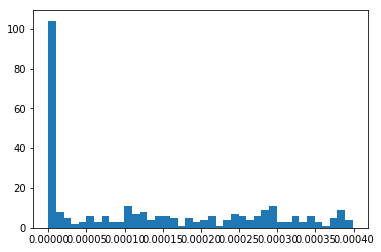

In [21]:
import matplotlib.pyplot as plt
eigs, eigvecs = np.linalg.eigh(gram)
print(np.min(eigs))
print(np.max(eigs))
plt.hist(eigs[:], 40)
plt.show()